# 📊 FOMC Polymarket Strategy - Data Exploration & Analysis

## 🎯 **Project Overview**

This notebook analyzes the relationship between **S&P 500 market movements** and **Polymarket prediction market data** for Federal Reserve interest rate decisions. We'll explore how market sentiment (via Polymarket probabilities) correlates with actual stock market performance.

### **Key Questions We'll Answer:**
- How do Polymarket rate cut probabilities correlate with S&P 500 returns?
- Can prediction market data be used to develop profitable trading strategies?
- What is the relationship between market uncertainty and volatility?
- Do rate cut expectations predict market movements?

### **Data Sources:**
- **S&P 500**: Daily OHLCV data with returns
- **Polymarket**: Prediction market probabilities for Fed rate decisions
- **Time Period**: July 2025 - October 2025

---


## Exploration of fully merged dataset

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = "../data/sp500_fed_merged_ml_ready.csv"

df = pd.read_csv(data_dir, index_col=0, parse_dates=True)
print(f"📊 Loaded data: {df.shape} records ")
print(df.columns)

📊 Loaded data: (279, 128) records 
Index(['Fed_Interest_Rates_November_2024_25_bps_decrease',
       'Fed_Interest_Rates_November_2024_25_bps_increase',
       'Fed_Interest_Rates_November_2024_50_bps_decrease',
       'Fed_Interest_Rates_November_2024_75_bps_decrease',
       'Fed_Interest_Rates_November_2024_No_Change',
       'Fed_Interest_Rates_November_2024_Other', 'Fed_abolished_in_2025_Price',
       'Fed_decision_in_December_25_bps_decrease',
       'Fed_decision_in_December_25_bps_increase',
       'Fed_decision_in_December_50_bps_decrease',
       ...
       'Volume', 'Daily_Return', 'Log_Return', 'High_Low_Range',
       'Open_Close_Range', 'Volume_MA_20', 'Volume_Ratio', 'Price_MA_20',
       'Price_MA_50', 'Volatility_20'],
      dtype='object', length=128)


In [20]:
print(df['Fed_abolished_in_2025_Price'])

Date
2024-08-05    0.0000
2024-08-06    0.0000
2024-08-07    0.0000
2024-08-08    0.0000
2024-08-09    0.0000
               ...  
2025-10-17    0.0135
2025-10-20    0.0125
2025-10-21    0.0125
2025-10-22    0.0120
2025-10-23    0.0115
Name: Fed_abolished_in_2025_Price, Length: 279, dtype: float64


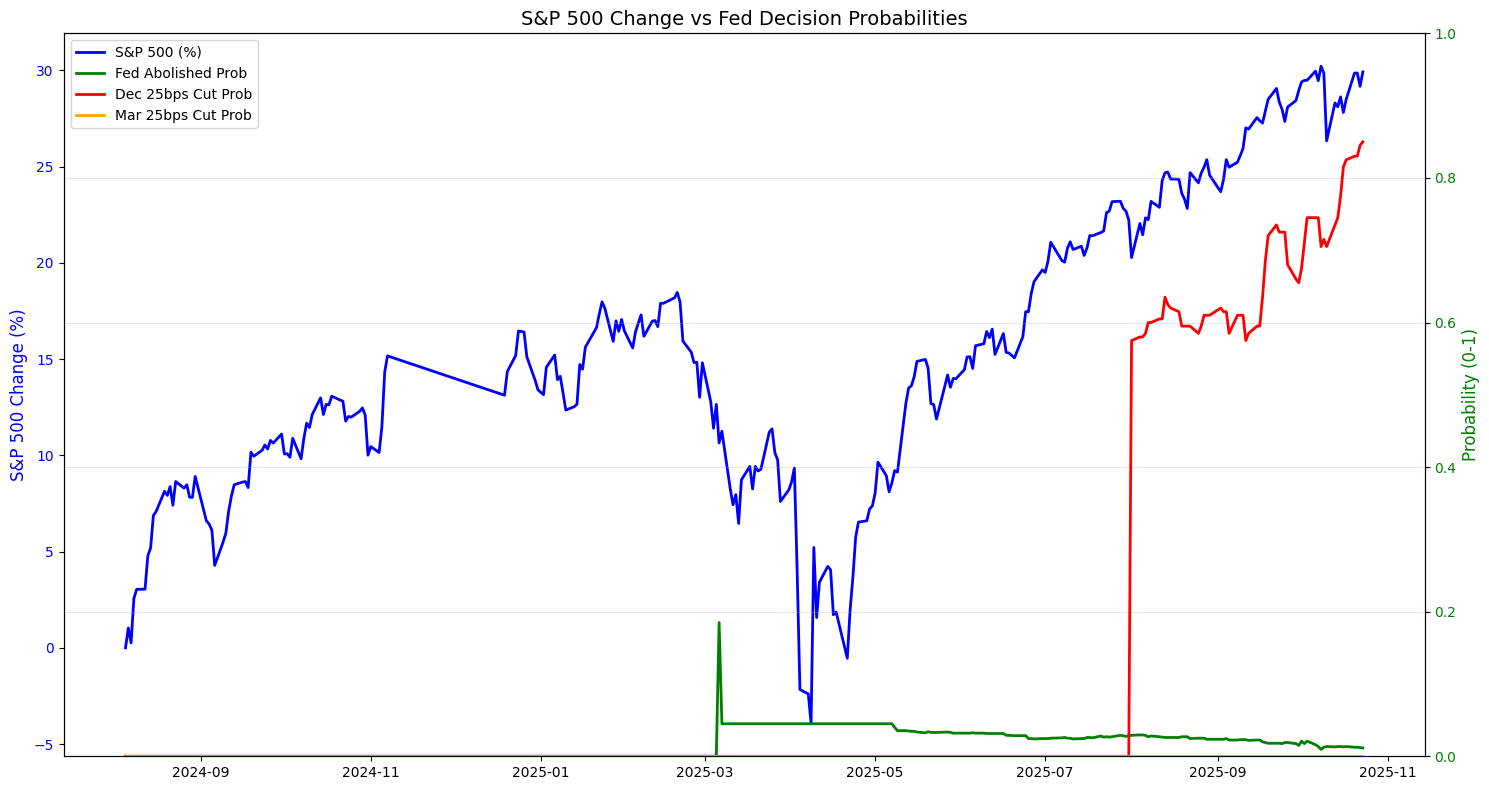


Maximum Changes:
S&P 500: 30.2% to -3.9%
Fed Abolished Prob: 0.185 to 0.000
Dec 25bps Cut Prob: 0.850 to 0.000


In [21]:
# Calculate percentage changes from start
cols_to_plot = [
        'Close', 'Fed_abolished_in_2025_Price',
       'Fed_decision_in_December_25_bps_decrease',
       'Fed_decision_in_December_25_bps_increase',
       'Fed_decision_in_December_50_bps_decrease',
       'Fed_decision_in_December_No_change',
       'Fed_decision_in_January_25_bps_decrease',
       'Fed_decision_in_January_25_bps_increase',
       'Fed_decision_in_January_50_bps_decrease',
       'Fed_decision_in_January_No_change',
       'Fed_decision_in_March_25_bps_decrease'
       ]

# Calculate percentage changes from start for S&P 500 only
df_pct = pd.DataFrame()
df_pct['Close'] = (df['Close'] / df['Close'].iloc[0] - 1) * 100

# Create the plot with two y-axes
plt.figure(figsize=(15, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot S&P 500 percentage change on left axis
ax1.plot(df.index, df_pct['Close'], 'b-', linewidth=2, label='S&P 500 (%)')
ax1.set_ylabel('S&P 500 Change (%)', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')

# Plot probabilities on right axis (0-1 scale)
ax2.plot(df.index, df['Fed_abolished_in_2025_Price'], 'g-', linewidth=2, 
         label='Fed Abolished Prob')
ax2.plot(df.index, df['Fed_decision_in_December_25_bps_decrease'], 'r-', 
         linewidth=2, label='Dec 25bps Cut Prob')
ax2.plot(df.index, df['Fed_decision_in_March_25_bps_decrease'], 'orange', 
         linewidth=2, label='Mar 25bps Cut Prob')
ax2.set_ylabel('Probability (0-1)', color='g', fontsize=12)
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylim(0, 1)  # Set probability axis from 0 to 1

# Title and grid
plt.title('S&P 500 Change vs Fed Decision Probabilities', fontsize=14)
plt.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# Print statistics
print("\nMaximum Changes:")
print(f"S&P 500: {df_pct['Close'].max():.1f}% to {df_pct['Close'].min():.1f}%")
print(f"Fed Abolished Prob: {df['Fed_abolished_in_2025_Price'].max():.3f} to {df['Fed_abolished_in_2025_Price'].min():.3f}")
print(f"Dec 25bps Cut Prob: {df['Fed_decision_in_December_25_bps_decrease'].max():.3f} to {df['Fed_decision_in_December_25_bps_decrease'].min():.3f}")

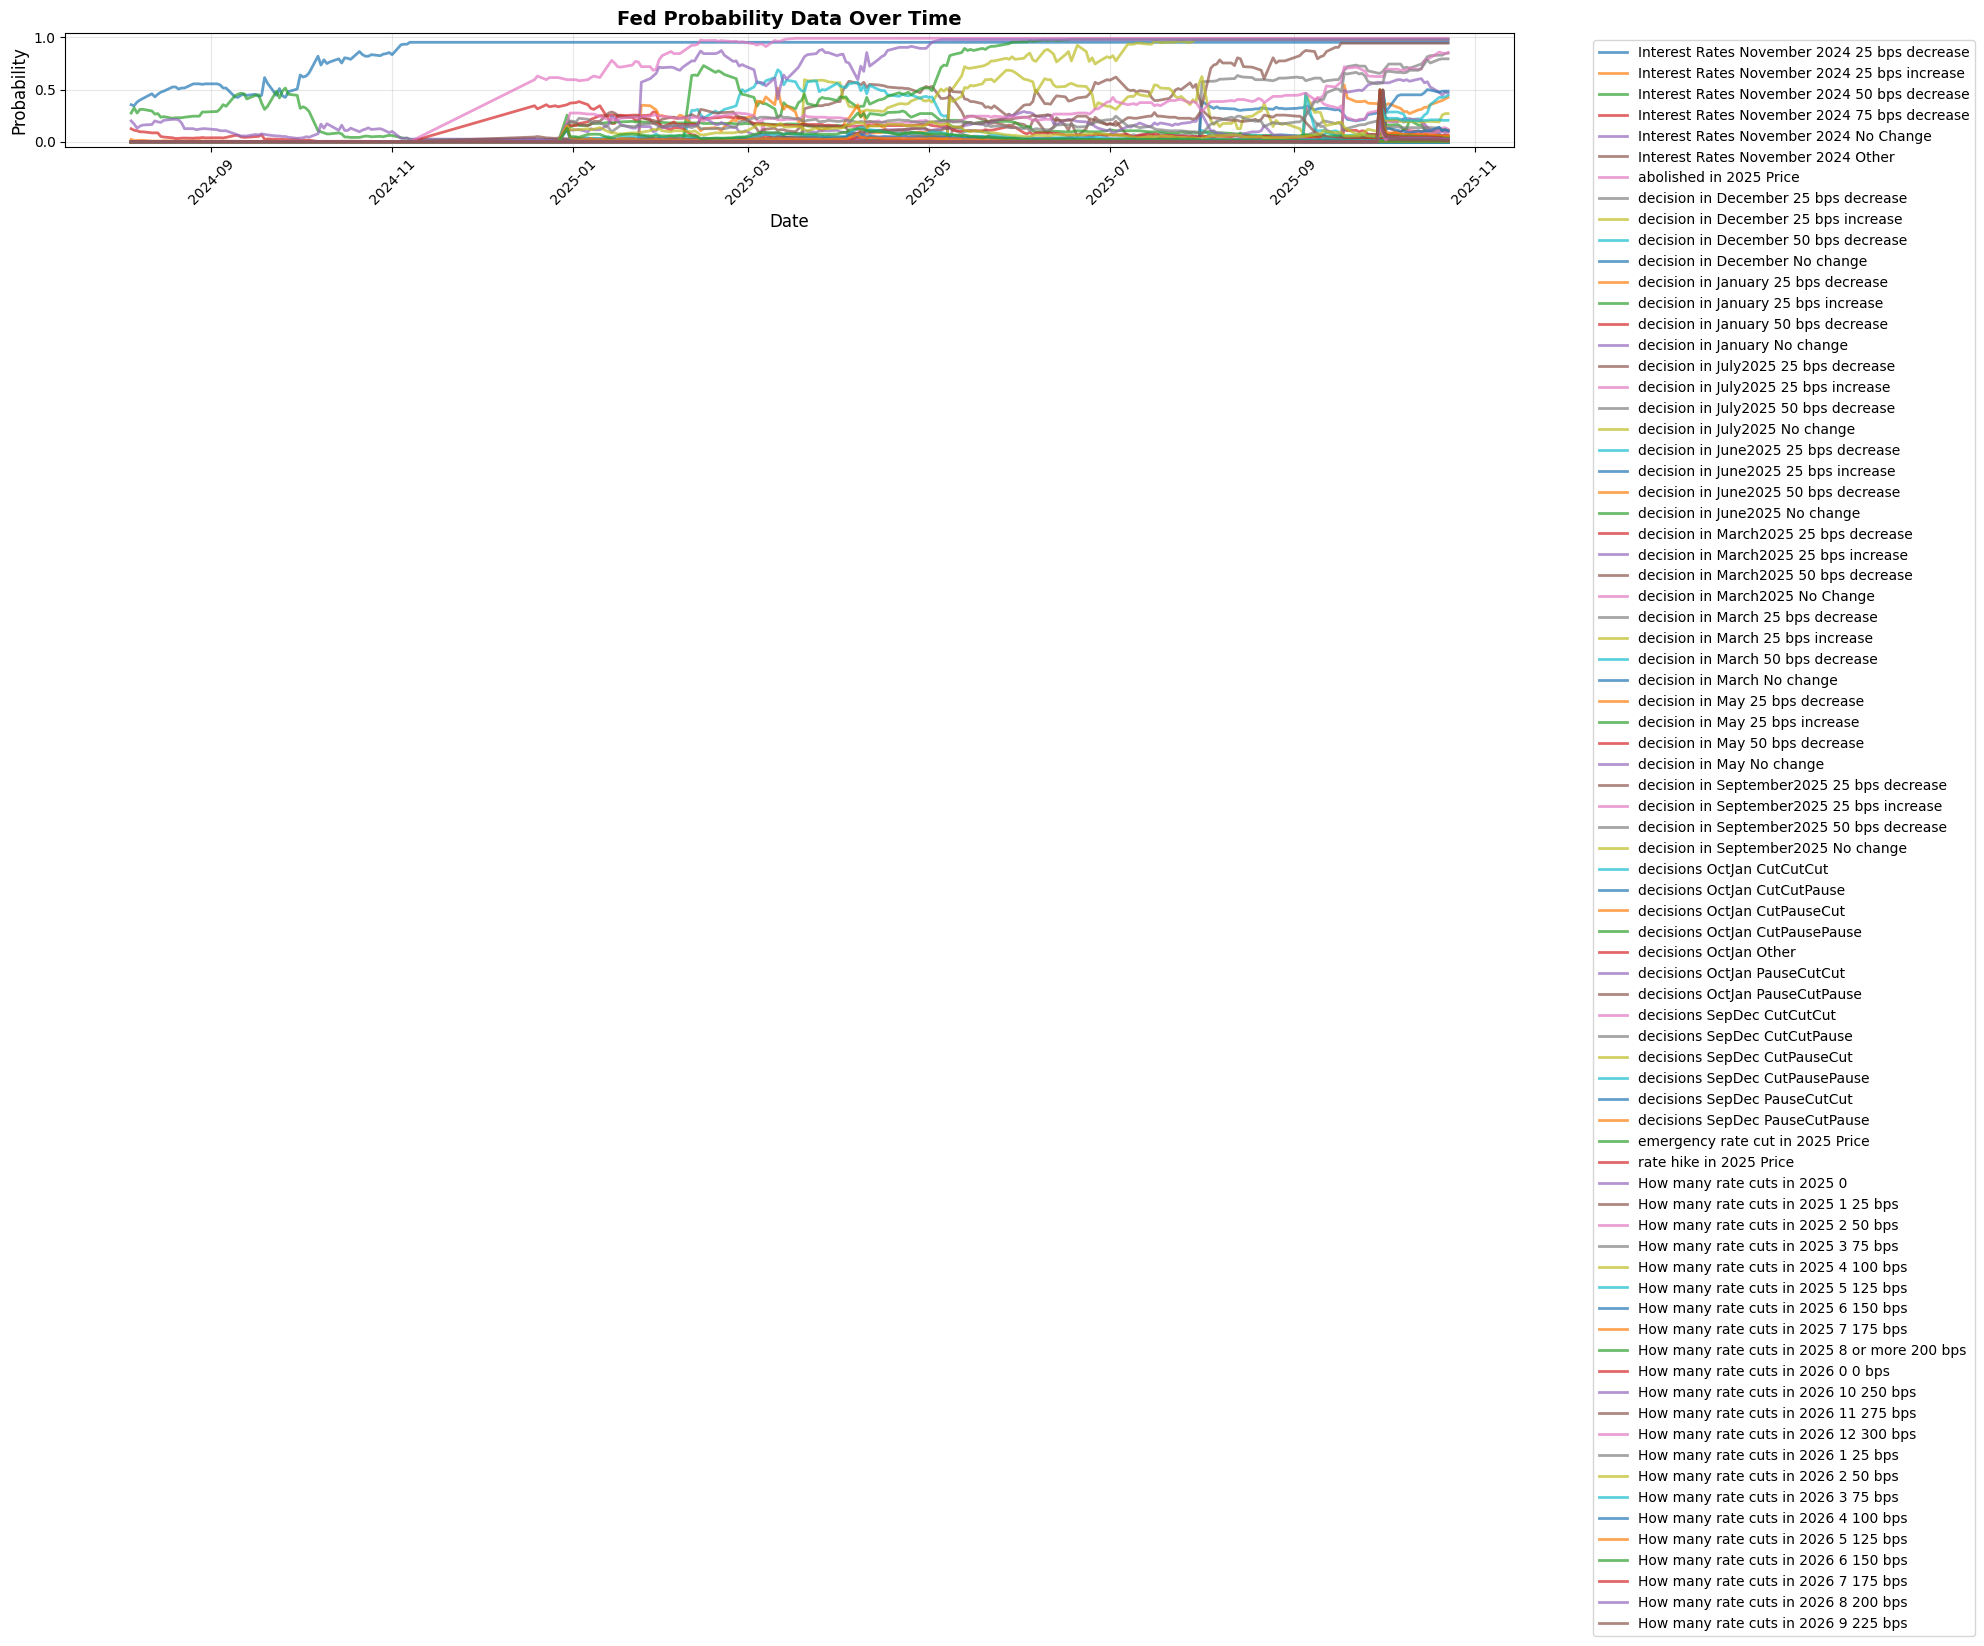


Summary Statistics:

Fed_Interest_Rates_November_2024_25_bps_decrease:
  Mean: 0.8705
  Max: 0.9535
  Min: 0.3450

Fed_Interest_Rates_November_2024_25_bps_increase:
  Mean: 0.0034
  Max: 0.0225
  Min: 0.0015

Fed_Interest_Rates_November_2024_50_bps_decrease:
  Mean: 0.0737
  Max: 0.5150
  Min: 0.0210

Fed_Interest_Rates_November_2024_75_bps_decrease:
  Mean: 0.0099
  Max: 0.1250
  Min: 0.0020

Fed_Interest_Rates_November_2024_No_Change:
  Mean: 0.0454
  Max: 0.2150
  Min: 0.0250

Fed_Interest_Rates_November_2024_Other:
  Mean: 0.0014
  Max: 0.0065
  Min: 0.0000

Fed_abolished_in_2025_Price:
  Mean: 0.0181
  Max: 0.1850
  Min: 0.0000

Fed_decision_in_December_25_bps_decrease:
  Mean: 0.1404
  Max: 0.8500
  Min: 0.0000

Fed_decision_in_December_25_bps_increase:
  Mean: 0.0031
  Max: 0.0600
  Min: 0.0000

Fed_decision_in_December_50_bps_decrease:
  Mean: 0.0137
  Max: 0.1100
  Min: 0.0000

Fed_decision_in_December_No_change:
  Mean: 0.0559
  Max: 0.3850
  Min: 0.0000

Fed_decision_in_Jan

In [22]:
# Plot all Fed probability data over time (excluding Trump nominations)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data_path = "../data/sp500_fed_merged_ml_ready.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)

# Get all Fed-related columns, excluding Trump nominations
fed_cols = [col for col in df.columns if 'Fed_' in col and 'Who_will' not in col]

# Create figure with adjusted size for better legend visibility
plt.figure(figsize=(20, 10))

# Plot each Fed probability
for col in fed_cols:
    # Clean up column name for legend
    legend_name = col.replace('Fed_', '').replace('_', ' ')
    plt.plot(df.index, df[col], label=legend_name, alpha=0.7, linewidth=2)

# Customize plot
plt.title('Fed Probability Data Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Rotate x-axis dates
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 50)
for col in fed_cols:
    print(f"\n{col}:")
    print(f"  Mean: {df[col].mean():.4f}")
    print(f"  Max: {df[col].max():.4f}")
    print(f"  Min: {df[col].min():.4f}")

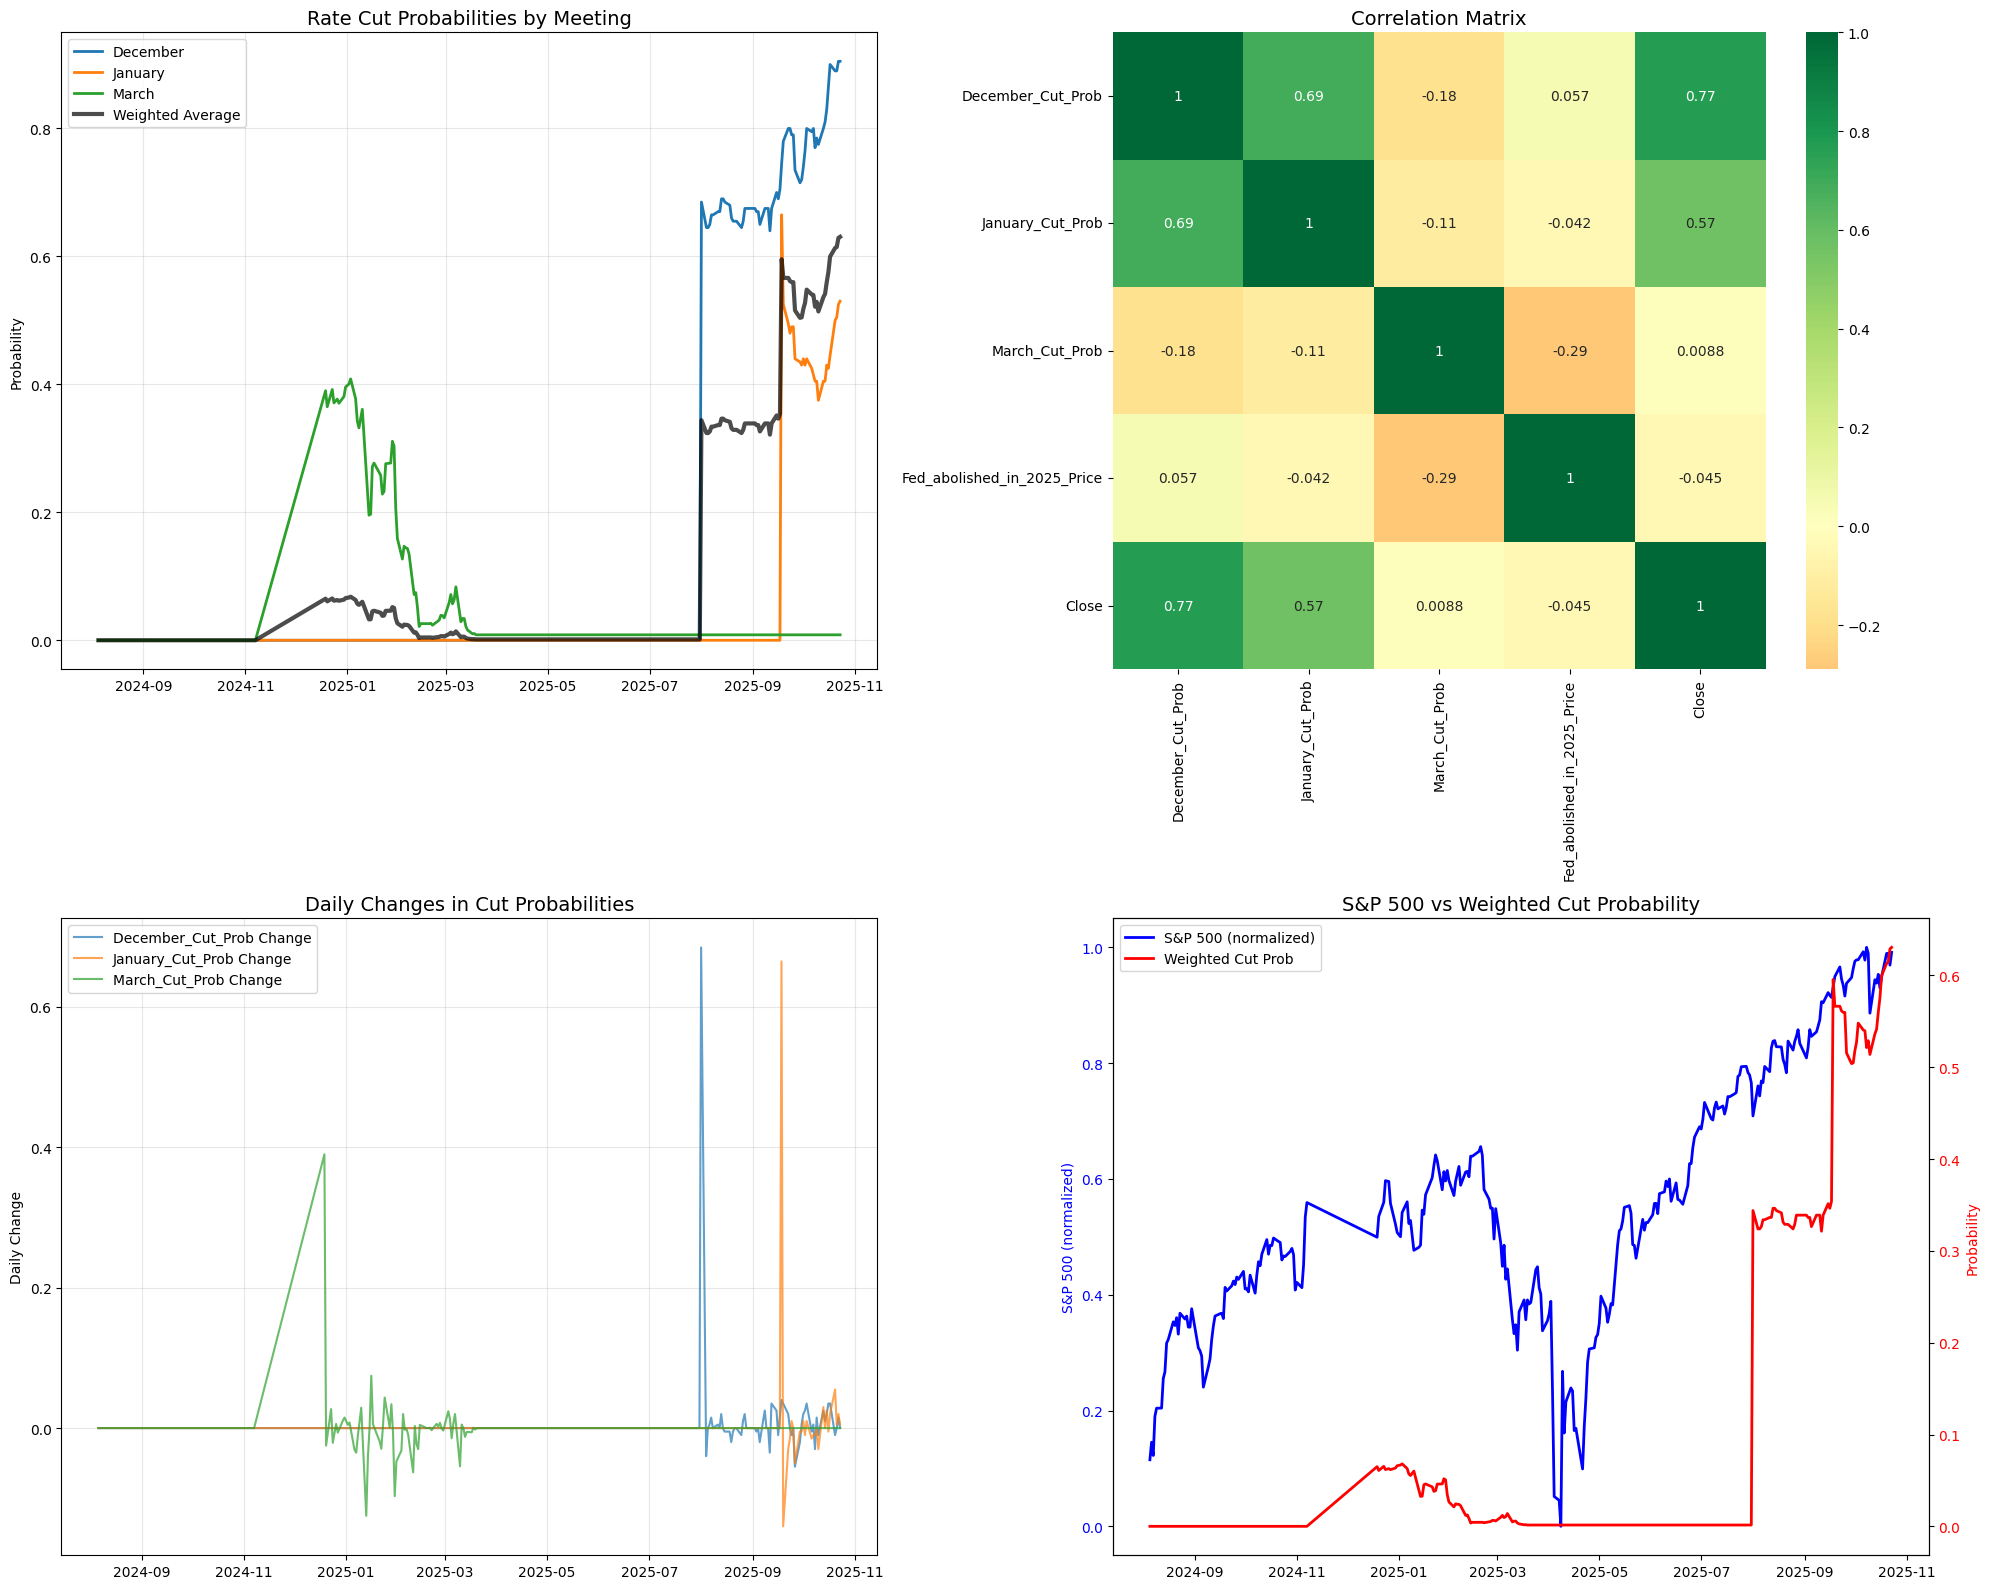


=== Summary Statistics ===

Correlations with S&P 500:
December_Cut_Prob: 0.767
January_Cut_Prob: 0.567
March_Cut_Prob: 0.009
Weighted_Cut_Prob: 0.774
Fed_abolished_in_2025_Price: -0.045

Probability Summary:

December_Cut_Prob:
  Mean: 0.154
  Std: 0.300
  Min: 0.000
  Max: 0.905

January_Cut_Prob:
  Mean: 0.043
  Std: 0.135
  Min: 0.000
  Max: 0.665

March_Cut_Prob:
  Mean: 0.042
  Std: 0.095
  Min: 0.000
  Max: 0.409

Weighted_Cut_Prob:
  Mean: 0.098
  Std: 0.182
  Min: 0.000
  Max: 0.631


In [23]:
# Analyze and combine Fed probabilities into meaningful indicators
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data_path = "../data/sp500_fed_merged_ml_ready.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)

# 1. Group probabilities by type
december_probs = [col for col in df.columns if 'December' in col]
january_probs = [col for col in df.columns if 'January' in col]
march_probs = [col for col in df.columns if 'March' in col]

# 2. Create aggregate indicators
df['December_Cut_Prob'] = df[[col for col in december_probs if 'decrease' in col]].sum(axis=1)
df['January_Cut_Prob'] = df[[col for col in january_probs if 'decrease' in col]].sum(axis=1)
df['March_Cut_Prob'] = df[[col for col in march_probs if 'decrease' in col]].sum(axis=1)

# 3. Calculate weighted probability (closer meetings have more weight)
df['Weighted_Cut_Prob'] = (
    df['December_Cut_Prob'] * 3 + 
    df['January_Cut_Prob'] * 2 + 
    df['March_Cut_Prob'] * 1
) / 6

# 4. Create correlation matrix
prob_cols = ['December_Cut_Prob', 'January_Cut_Prob', 'March_Cut_Prob', 
             'Fed_abolished_in_2025_Price', 'Close']
correlation_matrix = df[prob_cols].corr()

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Rate Cut Probabilities Over Time
ax1 = axes[0, 0]
ax1.plot(df.index, df['December_Cut_Prob'], label='December', linewidth=2)
ax1.plot(df.index, df['January_Cut_Prob'], label='January', linewidth=2)
ax1.plot(df.index, df['March_Cut_Prob'], label='March', linewidth=2)
ax1.plot(df.index, df['Weighted_Cut_Prob'], label='Weighted Average', 
         linewidth=3, color='black', alpha=0.7)
ax1.set_title('Rate Cut Probabilities by Meeting', fontsize=14)
ax1.set_ylabel('Probability')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Correlation Heatmap
ax2 = axes[0, 1]
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', center=0, ax=ax2)
ax2.set_title('Correlation Matrix', fontsize=14)

# Plot 3: Probability Changes
ax3 = axes[1, 0]
changes = df[['December_Cut_Prob', 'January_Cut_Prob', 'March_Cut_Prob']].diff()
for col in changes.columns:
    ax3.plot(df.index, changes[col], label=f'{col} Change', alpha=0.7)
ax3.set_title('Daily Changes in Cut Probabilities', fontsize=14)
ax3.set_ylabel('Daily Change')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: S&P 500 vs Weighted Probability
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()

# Normalize S&P 500 to 0-1 scale for comparison
sp500_norm = (df['Close'] - df['Close'].min()) / (df['Close'].max() - df['Close'].min())
ax4.plot(df.index, sp500_norm, 'b-', label='S&P 500 (normalized)', linewidth=2)
ax4_twin.plot(df.index, df['Weighted_Cut_Prob'], 'r-', 
              label='Weighted Cut Prob', linewidth=2)
ax4.set_title('S&P 500 vs Weighted Cut Probability', fontsize=14)
ax4.set_ylabel('S&P 500 (normalized)', color='b')
ax4_twin.set_ylabel('Probability', color='r')
ax4.tick_params(axis='y', labelcolor='b')
ax4_twin.tick_params(axis='y', labelcolor='r')

# Add both legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print("\nCorrelations with S&P 500:")
for col in ['December_Cut_Prob', 'January_Cut_Prob', 'March_Cut_Prob', 
            'Weighted_Cut_Prob', 'Fed_abolished_in_2025_Price']:
    corr = df[col].corr(df['Close'])
    print(f"{col}: {corr:.3f}")

print("\nProbability Summary:")
for col in ['December_Cut_Prob', 'January_Cut_Prob', 'March_Cut_Prob', 
            'Weighted_Cut_Prob']:
    print(f"\n{col}:")
    print(f"  Mean: {df[col].mean():.3f}")
    print(f"  Std: {df[col].std():.3f}")
    print(f"  Min: {df[col].min():.3f}")
    print(f"  Max: {df[col].max():.3f}")

In [ ]:
import re

# --- Identify bps-related columns (heuristic matching) ---
increase_cols = [c for c in df.columns if re.search(r'(?i)(increase|increas|raise|hike|up|bps_increase)', c)]
decrease_cols = [c for c in df.columns if re.search(r'(?i)(decrease|decreas|cut|down|bps_decrease)', c)]

print(f'Found {len(increase_cols)} increase cols, {len(decrease_cols)} decrease cols')
print('Increase cols sample:', increase_cols[:10])
print('Decrease cols sample:', decrease_cols[:10])

# --- Compute day-over-day deltas for each target column ---
target_cols = sorted(set(increase_cols + decrease_cols))
for col in target_cols:
    delta_col = col + '_delta'
    # safe diff (will introduce NaN in first row)
    df[delta_col] = df[col].diff()

# --- SIGNAL COUNTS WITH SEMANTICS ---
# For decrease-type columns (rate cuts): delta > 0 is GOOD (positive), delta < 0 is BAD (negative)
if decrease_cols:
    dec_delta_cols = [c + '_delta' for c in decrease_cols]
    dec_positive = (df[dec_delta_cols] > 0).sum(axis=1)   # increases in cut-prob => positive
    dec_negative = (df[dec_delta_cols] < 0).sum(axis=1)   # decreases in cut-prob => negative
else:
    dec_positive = 0
    dec_negative = 0

# For increase-type columns (rate hikes): delta < 0 is GOOD (positive, lower hike prob), delta > 0 is BAD (negative)
if increase_cols:
    inc_delta_cols = [c + '_delta' for c in increase_cols]
    inc_positive = (df[inc_delta_cols] < 0).sum(axis=1)   # decreases in hike-prob => positive
    inc_negative = (df[inc_delta_cols] > 0).sum(axis=1)   # increases in hike-prob => negative
else:
    inc_positive = 0
    inc_negative = 0

# Aggregate
df['num_positive_bps_signals'] = dec_positive + inc_positive
df['num_negative_bps_signals'] = dec_negative + inc_negative
df['net_bps_signal'] = df['num_positive_bps_signals'] - df['num_negative_bps_signals']

# (Optional) keep legacy counts for compatibility
if increase_cols:
    df['num_increase_cols_rising'] = (df[inc_delta_cols] > 0).sum(axis=1)
else:
    df['num_increase_cols_rising'] = 0
if decrease_cols:
    df['num_decrease_cols_falling'] = (df[dec_delta_cols] < 0).sum(axis=1)
else:
    df['num_decrease_cols_falling'] = 0


# --- 0) defensive cleanup: drop accidental repeated "_delta_delta..." columns ---
repeated = [c for c in df.columns if re.search(r'(_delta){2,}', c)]
if repeated:
    df = df.drop(columns=repeated, errors='ignore')
    print(f"dropped {len(repeated)} repeated _delta columns")

# --- Identify bps-related columns (heuristic matching) ---
# exclude any column that already contains 'delta' to avoid re-creating suffixes
inc_pattern = r'(?i)(increase|increas|raise|hike|up|bps_increase)'
dec_pattern = r'(?i)(decrease|decreas|cut|down|bps_decrease)'

increase_cols = [c for c in df.columns if re.search(inc_pattern, c) and 'delta' not in c.lower()]
decrease_cols = [c for c in df.columns if re.search(dec_pattern, c) and 'delta' not in c.lower()]

print(f'Found {len(increase_cols)} increase cols, {len(decrease_cols)} decrease cols')
print('Increase cols sample:', increase_cols[:10])
print('Decrease cols sample:', decrease_cols[:10])

# --- Compute day-over-day deltas for each target column (single-level "_delta" only) ---
target_cols = sorted(set(increase_cols + decrease_cols))

# coerce target columns to numeric where possible (safe conversion)
for col in target_cols:
    if df[col].dtype == object:
        coerced = pd.to_numeric(df[col], errors='coerce')
        # replace if column becomes mostly numeric
        if coerced.notna().sum() / len(coerced) > 0.5:
            df[col] = coerced

created = []
for col in target_cols:
    delta_col = f"{col}_delta"
    if delta_col in df.columns:
        # skip existing clean deltas
        continue
    # only create delta if column is numeric
    if np.issubdtype(df[col].dtype, np.number):
        df[delta_col] = df[col].diff()
        created.append(delta_col)
    else:
        # create NaN delta to preserve names (optional)
        df[delta_col] = np.nan
        created.append(delta_col)

print(f"created {len(created)} delta cols (sample): {created[:10]}")

# --- SIGNAL COUNTS WITH SEMANTICS ---
# build lists of delta column names that actually exist
dec_delta_cols = [f"{c}_delta" for c in decrease_cols if f"{c}_delta" in df.columns]
inc_delta_cols = [f"{c}_delta" for c in increase_cols if f"{c}_delta" in df.columns]

# helper to make zero-series when no columns matched
zero_series = pd.Series(0, index=df.index)

# For decrease-type columns (rate cuts): delta > 0 => positive signal
if dec_delta_cols:
    dec_positive = (df[dec_delta_cols] > 0).sum(axis=1)
    dec_negative = (df[dec_delta_cols] < 0).sum(axis=1)
else:
    dec_positive = zero_series.copy()
    dec_negative = zero_series.copy()

# For increase-type columns (rate hikes): delta < 0 => positive (lower hike prob)
if inc_delta_cols:
    inc_positive = (df[inc_delta_cols] < 0).sum(axis=1)
    inc_negative = (df[inc_delta_cols] > 0).sum(axis=1)
else:
    inc_positive = zero_series.copy()
    inc_negative = zero_series.copy()

# Aggregate counts
df['num_positive_bps_signals'] = dec_positive + inc_positive
df['num_negative_bps_signals'] = dec_negative + inc_negative
df['net_bps_signal'] = df['num_positive_bps_signals'] - df['num_negative_bps_signals']

# (Optional) legacy compatibility counts
if inc_delta_cols:
    df['num_increase_cols_rising'] = (df[inc_delta_cols] > 0).sum(axis=1)
else:
    df['num_increase_cols_rising'] = 0
if dec_delta_cols:
    df['num_decrease_cols_falling'] = (df[dec_delta_cols] < 0).sum(axis=1)
else:
    df['num_decrease_cols_falling'] = 0

# --- Final reporting ---
print(df[['num_positive_bps_signals','num_negative_bps_signals','net_bps_signal']].head(20))
print(f"Total columns now: {len(df.columns)}")
print("Some delta columns created (sample):", created[:20])

# Print a quick preview
print(df[['num_positive_bps_signals','num_negative_bps_signals','net_bps_signal']].head(20))
print(df.columns)

#df.to_excel("output.xlsx", index=True)

Found 10 increase cols, 58 decrease cols
Increase cols sample: ['Fed_Interest_Rates_November_2024_25_bps_increase', 'Fed_decision_in_December_25_bps_increase', 'Fed_decision_in_January_25_bps_increase', 'Fed_decision_in_July2025_25_bps_increase', 'Fed_decision_in_June2025_25_bps_increase', 'Fed_decision_in_March2025_25_bps_increase', 'Fed_decision_in_March_25_bps_increase', 'Fed_decision_in_May_25_bps_increase', 'Fed_decision_in_September2025_25_bps_increase', 'Fed_rate_hike_in_2025_Price']
Decrease cols sample: ['Fed_Interest_Rates_November_2024_25_bps_decrease', 'Fed_Interest_Rates_November_2024_50_bps_decrease', 'Fed_Interest_Rates_November_2024_75_bps_decrease', 'Fed_decision_in_December_25_bps_decrease', 'Fed_decision_in_December_50_bps_decrease', 'Fed_decision_in_January_25_bps_decrease', 'Fed_decision_in_January_50_bps_decrease', 'Fed_decision_in_July2025_25_bps_decrease', 'Fed_decision_in_July2025_50_bps_decrease', 'Fed_decision_in_June2025_25_bps_decrease']
Found 11 increase c

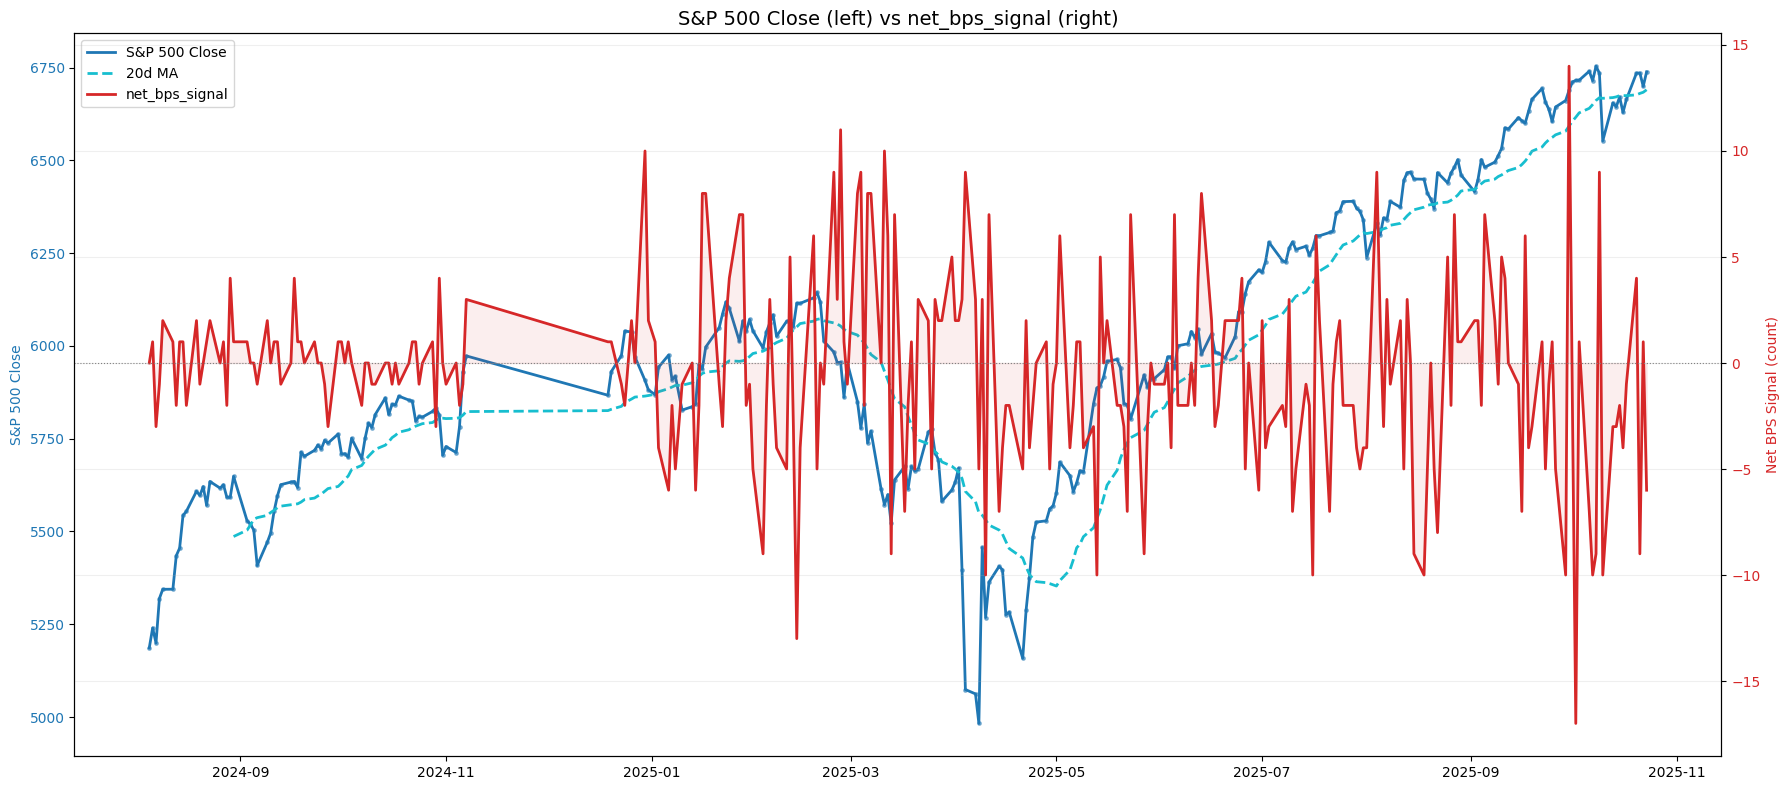

In [25]:
# Plot: large S&P Close on left axis and net_bps_signal on right axis
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Left axis: S&P 500 Close (line + many small points)
ax1.plot(df.index, df['Close'], color='tab:blue', linewidth=2, label='S&P 500 Close')
ax1.scatter(df.index, df['Close'], color='tab:blue', s=6, alpha=0.5)
ax1.plot(df.index, df['Close'].rolling(20).mean(), color='tab:cyan', linewidth=2, linestyle='--', label='20d MA')
ax1.set_ylabel('S&P 500 Close', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right axis: net_bps_signal (counts)
ax2.plot(df.index, df['net_bps_signal'], color='tab:red', linewidth=2, label='net_bps_signal')
ax2.fill_between(df.index, df['net_bps_signal'], color='tab:red', alpha=0.08)
ax2.axhline(0, color='gray', linewidth=0.8, linestyle=':')
ax2.set_ylabel('Net BPS Signal (count)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('S&P 500 Close (left) vs net_bps_signal (right)', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

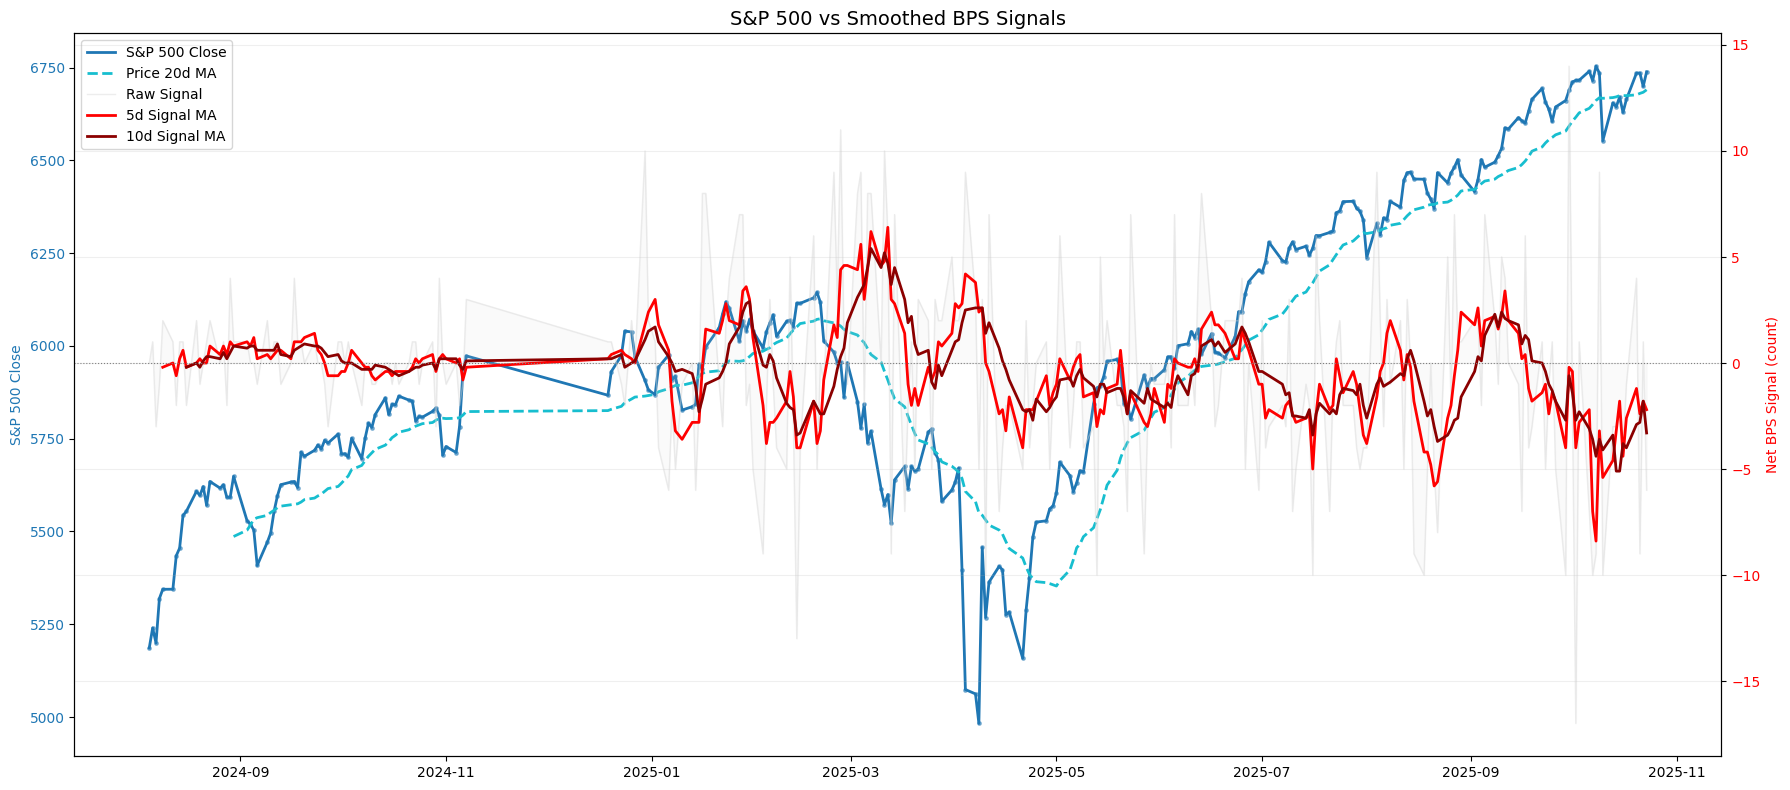

In [ ]:
# Plot: S&P Close and smoothed BPS signals
import matplotlib.pyplot as plt


# Define MA periods
SHORT_MA = 5
LONG_MA = 20

# Calculate moving averages for net_bps_signal
df['net_bps_signal_ma_short'] = df['net_bps_signal'].rolling(SHORT_MA).mean()
df['net_bps_signal_ma_long'] = df['net_bps_signal'].rolling(LONG_MA).mean()

plt.figure(figsize=(18, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Left axis: S&P 500 Close
ax1.plot(df.index, df['Close'], color='tab:blue', linewidth=2, label='S&P 500 Close')
ax1.scatter(df.index, df['Close'], color='tab:blue', s=6, alpha=0.5)
ax1.plot(df.index, df['Close'].rolling(20).mean(), color='tab:cyan', 
         linewidth=2, linestyle='--', label='Price 20d MA')
ax1.set_ylabel('S&P 500 Close', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right axis: net_bps_signal and its MAs
ax2.plot(df.index, df['net_bps_signal'], color='lightgray', 
         linewidth=1, alpha=0.4, label='Raw Signal')
ax2.plot(df.index, df['net_bps_signal_ma_short'], color='red',
         linewidth=2, label=f'{SHORT_MA}d Signal MA')
ax2.plot(df.index, df['net_bps_signal_ma_long'], color='darkred',
         linewidth=2, label=f'{LONG_MA}d Signal MA')
ax2.fill_between(df.index, df['net_bps_signal'], color='lightgray', alpha=0.1)
ax2.axhline(0, color='gray', linewidth=0.8, linestyle=':')
ax2.set_ylabel('Net BPS Signal (count)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('S&P 500 vs Smoothed BPS Signals', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

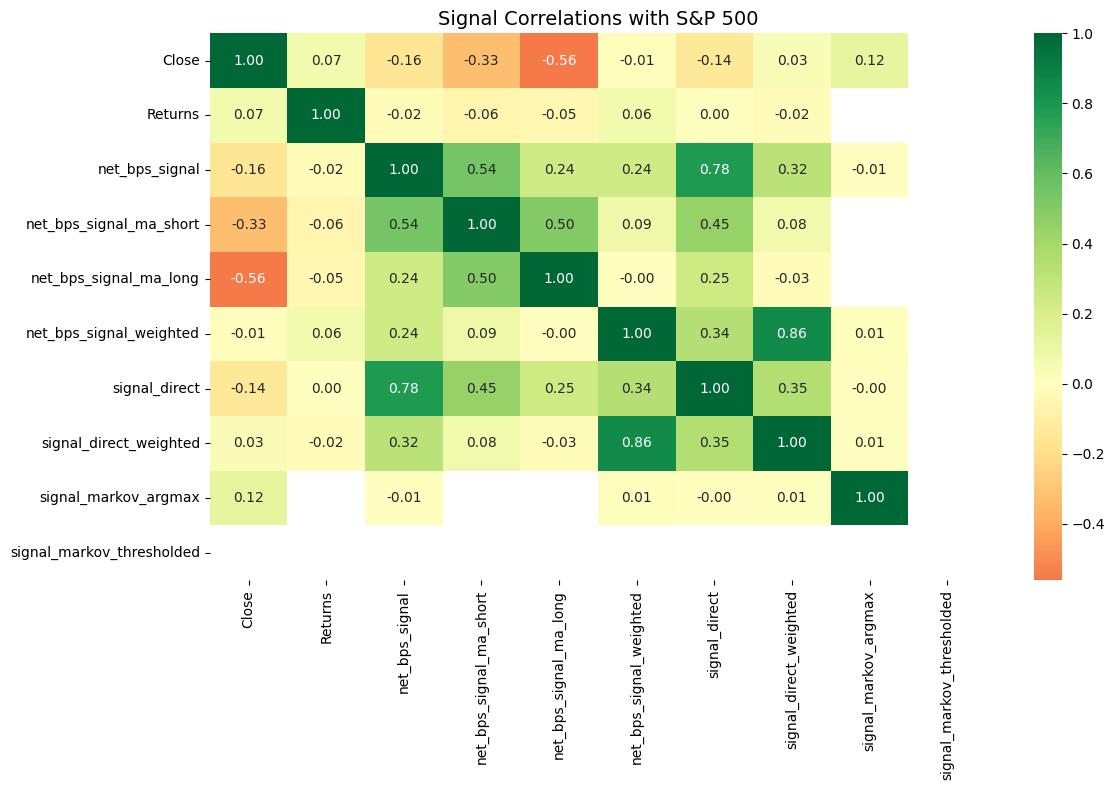


Correlations with S&P 500:

Price Level Correlations:
net_bps_signal: -0.157
net_bps_signal_ma_short: -0.332
net_bps_signal_ma_long: -0.561
net_bps_signal_weighted: -0.007
signal_direct: -0.141
signal_direct_weighted: 0.033
signal_markov_argmax: 0.119
signal_markov_thresholded: nan

Return Correlations:
net_bps_signal: -0.016
net_bps_signal_ma_short: -0.064
net_bps_signal_ma_long: -0.053
net_bps_signal_weighted: 0.061
signal_direct: 0.000
signal_direct_weighted: -0.021
signal_markov_argmax: nan
signal_markov_thresholded: nan

Next-Day Return Correlations:
net_bps_signal → Next-day Returns: -0.110
net_bps_signal_ma_short → Next-day Returns: -0.108
net_bps_signal_ma_long → Next-day Returns: -0.052
net_bps_signal_weighted → Next-day Returns: -0.063
signal_direct → Next-day Returns: -0.102
signal_direct_weighted → Next-day Returns: -0.046
signal_markov_argmax → Next-day Returns: -0.048
signal_markov_thresholded → Next-day Returns: nan


c:\Users\Michael\Code\ML-PortfolioManagement\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Michael\Code\ML-PortfolioManagement\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [30]:
# Analyze signal correlations with S&P 500
import seaborn as sns

# Calculate correlations for different signals
signal_cols = [
    'net_bps_signal',
    'net_bps_signal_ma_short',
    'net_bps_signal_ma_long',
    'net_bps_signal_weighted',
    'signal_direct',
    'signal_direct_weighted',
    'signal_markov_argmax',
    'signal_markov_thresholded'
]

# Create correlation matrix
corr_df = pd.DataFrame()
corr_df['Close'] = df['Close']
corr_df['Returns'] = df['Close'].pct_change()
for col in signal_cols:
    if col in df.columns:
        corr_df[col] = df[col]

correlation_matrix = corr_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
plt.title('Signal Correlations with S&P 500', fontsize=14)
plt.tight_layout()
plt.show()

# Print detailed correlations with S&P 500
print("\nCorrelations with S&P 500:")
print("\nPrice Level Correlations:")
for col in signal_cols:
    if col in df.columns:
        corr = corr_df['Close'].corr(corr_df[col])
        print(f"{col}: {corr:.3f}")

print("\nReturn Correlations:")
for col in signal_cols:
    if col in df.columns:
        corr = corr_df['Returns'].corr(corr_df[col])
        print(f"{col}: {corr:.3f}")

# Calculate lead-lag correlations (t+1)
print("\nNext-Day Return Correlations:")
for col in signal_cols:
    if col in df.columns:
        corr = corr_df['Returns'].shift(-1).corr(corr_df[col])
        print(f"{col} → Next-day Returns: {corr:.3f}")

# strategy 1


net_bps_signal summary:
count    279.000000
mean      -0.394265
std        4.428745
min      -17.000000
25%       -3.000000
50%        0.000000
75%        2.000000
max       14.000000
Name: net_bps_signal, dtype: float64

State counts:
state
up         132
down       112
neutral     35
Name: count, dtype: int64

Raw transition counts (rows = prev state):
state    down  neutral  up
state                     
down       48       13  51
neutral    14        4  17
up         50       17  64

Normalized transition probabilities:
state        down   neutral        up
state                                
down     0.428571  0.116071  0.455357
neutral  0.400000  0.114286  0.485714
up       0.381679  0.129771  0.488550


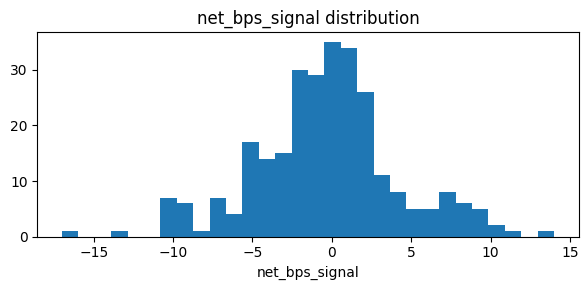


Performance (cumulative returns):
Buy-hold intraday: 14.25%
Markov argmax: 13.48%  | trades: 278  | mean conf: 0.47
Markov thresholded (thr=0.5): 0.00%  | trades: 0  | mean conf (trades): nan
Direct-sign: 15.79%  | trades: 244  | mean abs(net_bps): 3.26


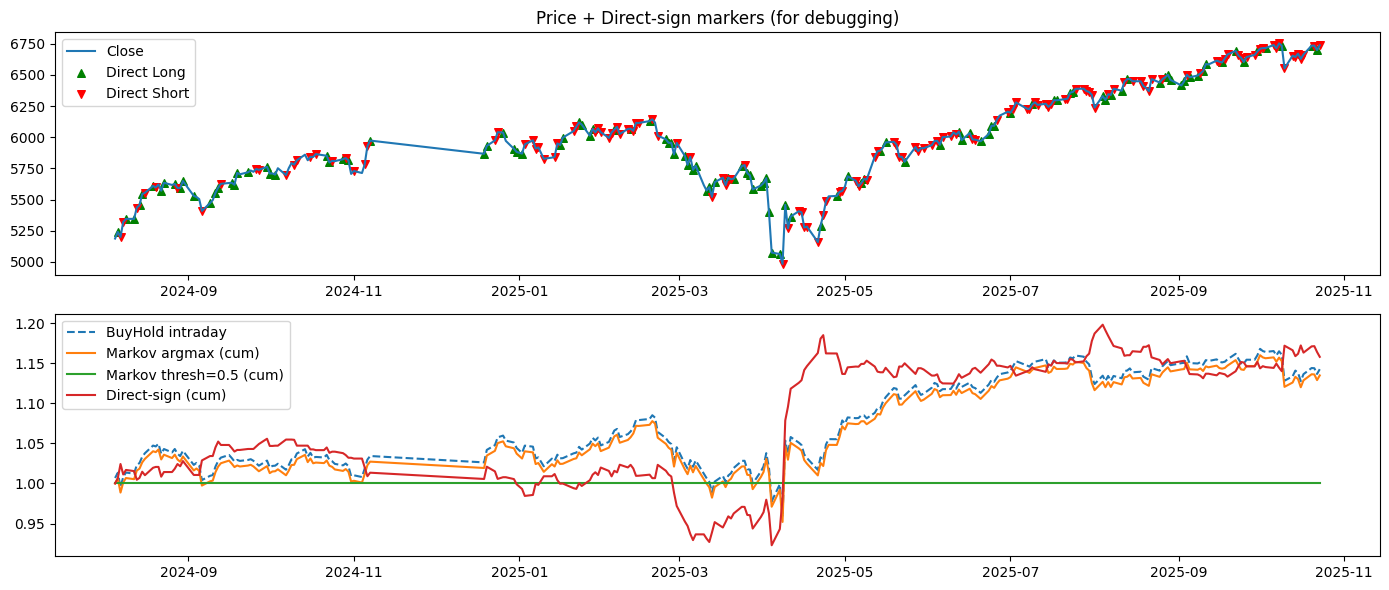


Hints:
- If state counts show large imbalance (many "down"), net_bps_signal may be biased. Check how counts were computed (increase/decrease mapping).
- Consider using thresholded Markov (shown) to avoid low-confidence argmax trades).
- Direct-sign uses current net_bps_signal sign and avoids Markov; useful baseline.


In [27]:
# Diagnostics + fixes for biased 'short' signals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make local copy (safe to re-run)
df = df.copy()

# Quick diagnostics of net_bps_signal and state distribution
print('\nnet_bps_signal summary:')
print(df['net_bps_signal'].describe())
df['state'] = np.where(df['net_bps_signal'] > 0, 'down',
                       np.where(df['net_bps_signal'] < 0, 'up', 'neutral'))
print('\nState counts:')
print(df['state'].value_counts())

# Raw transition counts and normalized matrix (1-step)
trans_counts = pd.crosstab(df['state'].shift(1), df['state']).fillna(0).astype(int)
print('\nRaw transition counts (rows = prev state):')
print(trans_counts)
trans_prob = trans_counts.div(trans_counts.sum(axis=1).replace(0,1), axis=0).fillna(0)
print('\nNormalized transition probabilities:')
print(trans_prob)

# Plot simple histogram of net_bps_signal to check skew
plt.figure(figsize=(6,3))
plt.hist(df['net_bps_signal'].dropna(), bins=30)
plt.title('net_bps_signal distribution')
plt.xlabel('net_bps_signal')
plt.tight_layout()
plt.show()

# If prev state not seen, fallback to 'neutral' row of probs (or uniform)
for s in ['down','neutral','up']:
    if s not in trans_prob.index:
        trans_prob.loc[s] = [1/3,1/3,1/3]
trans_prob = trans_prob[['down','neutral','up']].loc[['down','neutral','up']]

# Predict using argmax (original) but compute confidence (max prob)
def predict_argmax(prev):
    if pd.isna(prev):
        return 'neutral', 1/3
    row = trans_prob.loc[prev]
    mx = row.max()
    return row.idxmax(), mx

df['prev_state'] = df['state'].shift(1)
preds = df['prev_state'].apply(predict_argmax)
df['pred_state_argmax'] = preds.map(lambda x: x[0])
df['pred_conf'] = preds.map(lambda x: x[1])

# Option A: thresholded Markov - trade only if max prob >= threshold
THRESH = 0.5
df['signal_markov_argmax'] = df['pred_state_argmax'].map({'up':1,'neutral':0,'down':-1}).fillna(0).astype(int)
df['signal_markov_thresholded'] = df.apply(
    lambda r: 0 if r['pred_conf'] < THRESH else (1 if r['pred_state_argmax']=='up' else (-1 if r['pred_state_argmax']=='down' else 0)),
    axis=1
)

# Option B: direct-sign strategy from net_bps_signal (immediate signal) - no Markov
df['signal_direct'] = np.sign(df['net_bps_signal']).fillna(0).astype(int)

# Ensure Open/Close exist
if not {'Open','Close'}.issubset(df.columns):
    raise ValueError('Open/Close missing for intraday backtest')

# Intraday returns
df['intraday_ret'] = df['Close'] / df['Open'] - 1.0

def backtest_signal(sig_col):
    res = pd.Series(index=df.index, dtype=float)
    res = df[sig_col] * df['intraday_ret']
    cum = (1 + res.fillna(0)).cumprod()
    return res, cum

df['ret_markov_argmax'], df['cum_markov_argmax'] = backtest_signal('signal_markov_argmax')
df['ret_markov_thresh'], df['cum_markov_thresh'] = backtest_signal('signal_markov_thresholded')
df['ret_direct'], df['cum_direct'] = backtest_signal('signal_direct')
df['cum_buyhold'] = (1 + df['intraday_ret'].fillna(0)).cumprod()

# Summary metrics
def summary(cum_series, ret_series, name):
    total = cum_series.iloc[-1] - 1
    n = (df[name.replace('cum_','ret_').replace('cum','ret')] != 0).sum() if 'markov' in name or 'direct' in name else 0
    return total, n

print('\nPerformance (cumulative returns):')
print(f"Buy-hold intraday: {(df['cum_buyhold'].iloc[-1]-1):.2%}")
print(f"Markov argmax: {(df['cum_markov_argmax'].iloc[-1]-1):.2%}  | trades: {(df['signal_markov_argmax']!=0).sum()}  | mean conf: {df['pred_conf'].mean():.2f}")
print(f"Markov thresholded (thr={THRESH}): {(df['cum_markov_thresh'].iloc[-1]-1):.2%}  | trades: {(df['signal_markov_thresholded']!=0).sum()}  | mean conf (trades): {df.loc[df['pred_conf']>=THRESH,'pred_conf'].mean():.2f}")
print(f"Direct-sign: {(df['cum_direct'].iloc[-1]-1):.2%}  | trades: {(df['signal_direct']!=0).sum()}  | mean abs(net_bps): {df['net_bps_signal'].abs().mean():.2f}")

# Plot comparison
plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.plot(df.index, df['Close'], label='Close', color='tab:blue')
plt.scatter(df.index[df['signal_direct']==1], df['Close'][df['signal_direct']==1], marker='^', color='green', s=30, label='Direct Long')
plt.scatter(df.index[df['signal_direct']==-1], df['Close'][df['signal_direct']==-1], marker='v', color='red', s=30, label='Direct Short')
plt.title('Price + Direct-sign markers (for debugging)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df.index, df['cum_buyhold'], label='BuyHold intraday', linestyle='--')
plt.plot(df.index, df['cum_markov_argmax'], label='Markov argmax (cum)')
plt.plot(df.index, df['cum_markov_thresh'], label=f'Markov thresh={THRESH} (cum)')
plt.plot(df.index, df['cum_direct'], label='Direct-sign (cum)')
plt.legend()
plt.tight_layout()
plt.show()

# Quick action hints:
print('\nHints:')
print('- If state counts show large imbalance (many "down"), net_bps_signal may be biased. Check how counts were computed (increase/decrease mapping).')
print('- Consider using thresholded Markov (shown) to avoid low-confidence argmax trades).')
print('- Direct-sign uses current net_bps_signal sign and avoids Markov; useful baseline.')

# strategy 2


Implementing time-weighted signals...

Updated Performance (including weighted signals):
Buy-hold intraday: 14.25%
Original Direct: 15.79%  | trades: 244
Weighted Direct: 0.78%  | trades: 140


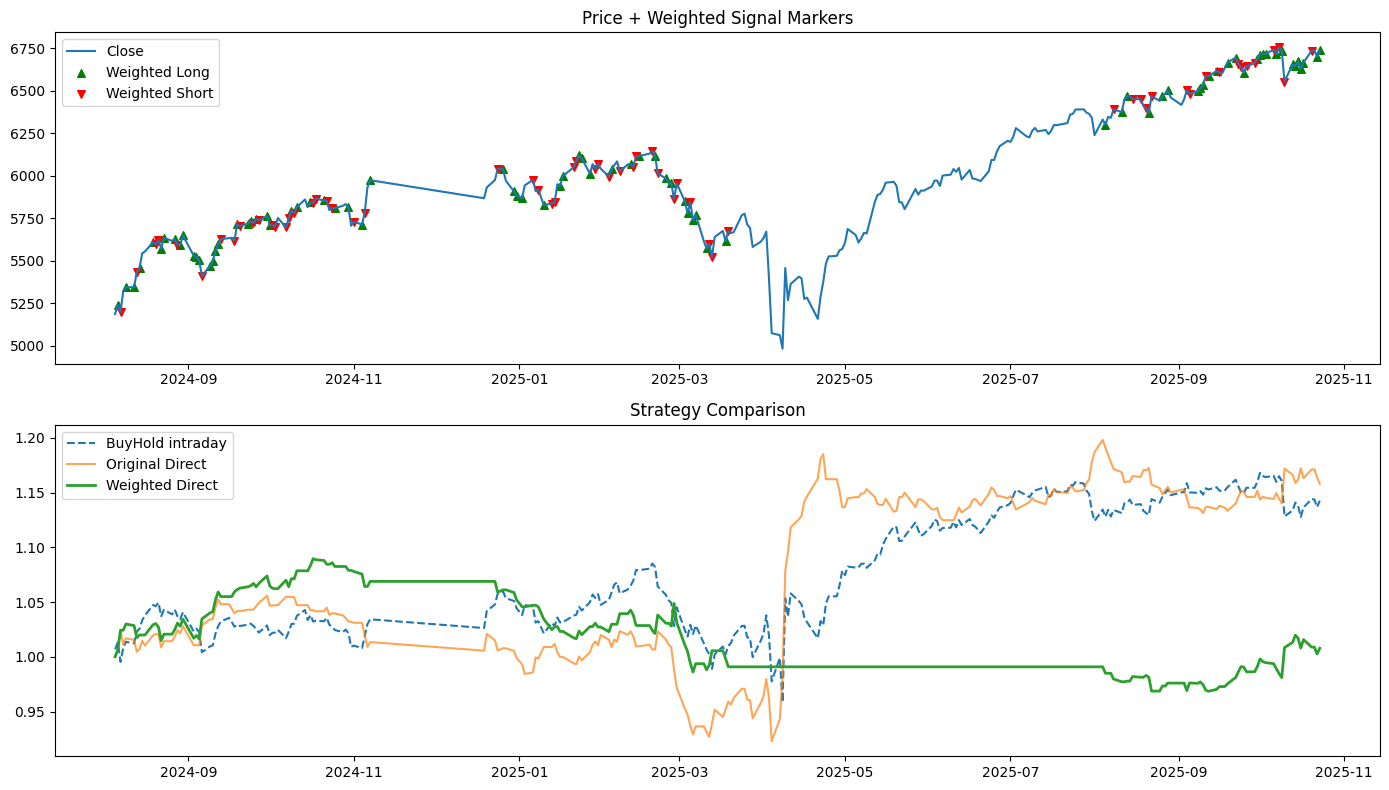

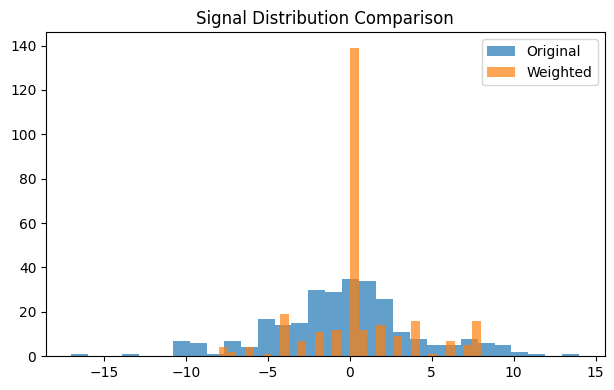

In [28]:
# After the existing Markov code...
# ...existing code...

# --- Time-weighted signal implementation ---
print("\nImplementing time-weighted signals...")

# Define meeting weights (closer meetings have higher weight)
meeting_weights = {
    'November': 4,
    'December': 3,
    'January': 2, 
    'March': 1
}

def calculate_weighted_signal(df, decrease_cols, increase_cols):
    signals = pd.Series(0, index=df.index)
    
    for meeting, weight in meeting_weights.items():
        # Get columns for this meeting
        dec_cols = [c for c in decrease_cols if meeting in c]
        inc_cols = [c for c in increase_cols if meeting in c]
        
        # Calculate meeting-specific deltas
        if dec_cols:
            dec_deltas = df[[c + '_delta' for c in dec_cols if c + '_delta' in df.columns]]
            dec_signal = np.sign(dec_deltas.sum(axis=1))
            signals += weight * dec_signal
            
        if inc_cols:
            inc_deltas = df[[c + '_delta' for c in inc_cols if c + '_delta' in df.columns]]
            inc_signal = -np.sign(inc_deltas.sum(axis=1))  # Note the negative sign
            signals += weight * inc_signal
            
    return signals

# Calculate new weighted signals
df['net_bps_signal_weighted'] = calculate_weighted_signal(df, decrease_cols, increase_cols)
df['signal_direct_weighted'] = np.sign(df['net_bps_signal_weighted']).fillna(0).astype(int)

# Backtest weighted strategy
df['ret_direct_weighted'], df['cum_direct_weighted'] = backtest_signal('signal_direct_weighted')

# Print updated performance comparison
print('\nUpdated Performance (including weighted signals):')
print(f"Buy-hold intraday: {(df['cum_buyhold'].iloc[-1]-1):.2%}")
print(f"Original Direct: {(df['cum_direct'].iloc[-1]-1):.2%}  | trades: {(df['signal_direct']!=0).sum()}")
print(f"Weighted Direct: {(df['cum_direct_weighted'].iloc[-1]-1):.2%}  | trades: {(df['signal_direct_weighted']!=0).sum()}")

# Plot updated comparison
plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(df.index, df['Close'], label='Close', color='tab:blue')
plt.scatter(df.index[df['signal_direct_weighted']==1], 
           df['Close'][df['signal_direct_weighted']==1], 
           marker='^', color='green', s=30, label='Weighted Long')
plt.scatter(df.index[df['signal_direct_weighted']==-1], 
           df['Close'][df['signal_direct_weighted']==-1], 
           marker='v', color='red', s=30, label='Weighted Short')
plt.title('Price + Weighted Signal Markers')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df.index, df['cum_buyhold'], label='BuyHold intraday', linestyle='--')
plt.plot(df.index, df['cum_direct'], label='Original Direct', alpha=0.7)
plt.plot(df.index, df['cum_direct_weighted'], label='Weighted Direct', linewidth=2)
plt.title('Strategy Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# Compare signal distributions
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df['net_bps_signal'].dropna(), bins=30, alpha=0.7, label='Original')
plt.hist(df['net_bps_signal_weighted'].dropna(), bins=30, alpha=0.7, label='Weighted')
plt.title('Signal Distribution Comparison')
plt.legend()
plt.tight_layout()
plt.show()